In [2]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import lasio
from pyesmda import ESMDA
from scipy.io import loadmat
from numdifftools import Jacobian, Hessian
from scipy import signal, stats, linalg, optimize

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
def check_torch():
    torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
    count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
    print('\n'+'-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
    print('# Device(s) available: {}, Name(s): {}'.format(count, name))
    print('-'*60+'\n')
    return None

def plot_curve(ax, df, curve, lb=None, ub=None, color='k', pad=0, s=2, mult=1,
            units:str=None, mask=None, offset:int=0, title:str=None, label:str=None,
            semilog:bool=False, bar:bool=False, fill:bool=None, rightfill:bool=False,
            marker=None, edgecolor=None, ls=None, alpha=None):
        if mask is None:
            x, y = -offset+mult*df[curve], df.index
        else:
            x, y = -offset+mult*df[curve][mask], df.index[mask]
        lb = x[~np.isnan(x)].min() if lb is None else lb
        ub = x[~np.isnan(x)].max() if ub is None else ub
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linestyle=ls, linewidth=s)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha)
            else:
                ax.plot(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linewidth=s, linestyle=ls)
        if fill:
            if rightfill:
                ax.fill_betweenx(y, x, ub, alpha=alpha, color=color)
            else:
                ax.fill_betweenx(y, lb, x, alpha=alpha, color=color)
        if units is None:
            if hasattr(df, 'curvesdict'):
                units = df.curvesdict[curve].unit
            else:
                units = ''
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both')
        ax.set_title(title, weight='bold') if title != None else None
        xlab = label if label is not None else curve
        if offset != 0:
            ax.set_xlabel('{} [{}] with {} offset'.format(xlab, units, offset), color=color, weight='bold')
        else:
            ax.set_xlabel('{} [{}]'.format(xlab, units), color=color, weight='bold')
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=s)
        ax.spines['top'].set_position(('axes', 1+pad/100))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(2)
        if ls is not None:
            ax.spines['top'].set_linestyle(ls)
        return None

def plot_loss(losses_df, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.plot(losses_df['train'], label='Training')
    plt.plot(losses_df['valid'], label='Validation')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xlim(0, losses_df.shape[0]); plt.ylim(0, None)
    plt.grid(True, which='both'); plt.legend()
    plt.tight_layout(); plt.show()
    return None

def error_metrics(df):
    mse_rv = mean_squared_error(df['Rv'], df['Rv_sim'])
    mse_rh = mean_squared_error(df['Rh'], df['Rh_sim'])
    r2_rv = r2_score(df['Rv'], df['Rv_sim'])*100
    r2_rh = r2_score(df['Rh'], df['Rh_sim'])*100
    sterr_rv = np.mean(np.abs(df['Rv']-df['Rv_sim'])) / np.std(np.abs(df['Rv']-df['Rv_sim']))
    sterr_rh = np.mean(np.abs(df['Rh']-df['Rh_sim'])) / np.std(np.abs(df['Rh']-df['Rh_sim']))
    mape_rv = mean_absolute_percentage_error(df['Rv'], df['Rv_sim']) * 100
    mape_rh = mean_absolute_percentage_error(df['Rh'], df['Rh_sim']) * 100
    print('Mean Squared Error - Rv: {:.4f}  | Rh: {:.4f}'.format(mse_rv, mse_rh))
    print('R2 Score           - Rv: {:.3f}  | Rh: {:.3f}'.format(r2_rv, r2_rh))
    print('Standard Error     - Rv: {:.4f}  | Rh: {:.4f}'.format(sterr_rv, sterr_rh))
    print('MAPE               - Rv: {:.3f}%  | Rh: {:.3f}%'.format(mape_rv, mape_rh))
    return None

In [3]:
class PINNLoss(nn.Module):
    def __init__(self, dd_flag:bool=True, ddmax=100, lambda_reg=1e-10, lambda_p=2):
        super(PINNLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p   = lambda_p
        self.dd_flag    = dd_flag
        self.ddmax      = ddmax

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]/self.ddmax
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]
        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        eq1 = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        if self.dd_flag:
            wd1, wd2 = 1/Rv_true/dd_true, 1*Rh_true/dd_true
        else:
            wd1, wd2 = 1/Rv_true, 1*Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg*torch.norm(outputs, p=self.lambda_p)

        return  costf + regPa

class DataLoss(nn.Module):
    def __init__(self, loss_fn=nn.MSELoss(), lambda_p=2):
        super(DataLoss, self).__init__()
        self.dd_loss = loss_fn
        self.lambda_p = lambda_p

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]
        
        Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
        Rh_sim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
        v_loss = self.dd_loss(Rv_sim, Rv_true)
        h_loss = self.dd_loss(Rh_sim, Rh_true)
        
        return torch.norm(torch.stack([v_loss, h_loss], dim=-1), p=self.lambda_p)

class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult*torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

***

In [4]:
well_moraine_1 = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/CPAI_Moraine_1_RTScanner_Dip_3600ft_5560ft_6in_sample.las').df()
well_moraine_oh = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_OH_DATA.las').df()
well_moraine_rvrh = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_RVRH.las').df()

well_moraine_c1 = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_1_VSAND.las').df()
well_moraine_c2 = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_2_VSAND.las').df()
well_moraine_c3 = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_3_VSAND.las').df()
well_moraine_core = pd.DataFrame(pd.concat([well_moraine_c1['NTG'], well_moraine_c2['NTG'], well_moraine_c3['NTG']])).replace(0, np.nan).dropna()
well_moraine_xrd = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_XRD_VCLAY.las').df()

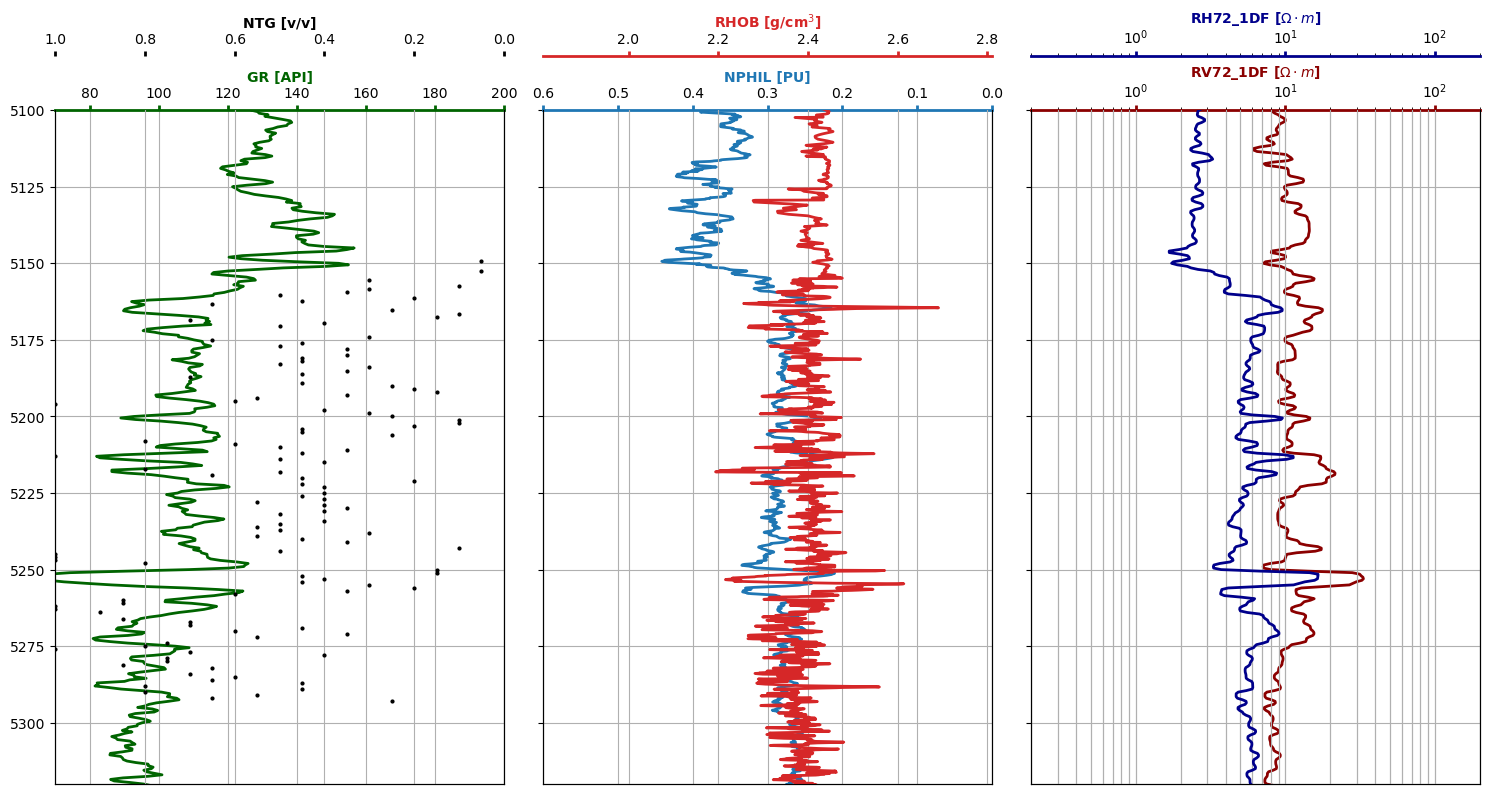

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15,8), sharey=True)
ax1, ax2, ax3 = axs

ax11 = ax1.twiny()
plot_curve(ax1, well_moraine_1, 'GR', units='API', color='darkgreen', lb=70, ub=200)
plot_curve(ax11, well_moraine_core, 'NTG', units='v/v', marker='o', ls='', color='black', lb=1, ub=0, pad=8)

ax21 = ax2.twiny()
plot_curve(ax2, well_moraine_oh, 'NPHIL', units='PU', color='tab:blue', lb=0.6, ub=0.0)
plot_curve(ax21, well_moraine_oh, 'RHOB', units='g/cm$^3$', color='tab:red', lb=1.81, ub=2.81, pad=8)

ax31 = ax3.twiny()
plot_curve(ax3, well_moraine_1, 'RV72_1DF', units=r'$\Omega \cdot m$', color='darkred', lb=0.2, ub=200, semilog=True)
plot_curve(ax31, well_moraine_1, 'RH72_1DF', units=r'$\Omega \cdot m$', color='darkblue', lb=0.2, ub=200, semilog=True, pad=8)

ax1.set(ylim=(5100, 5320))
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***

In [6]:
check_torch()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.5.1.post303 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------



X_train: 374 | X_valid: 67
# paramters: 17,154
Epoch: 0 | Loss: 1302.8798 | Valid Loss: 501.8425
Epoch: 100 | Loss: 116.2551 | Valid Loss: 86.1840
Epoch: 200 | Loss: 59.4499 | Valid Loss: 48.3388
Epoch: 300 | Loss: 83.3438 | Valid Loss: 89.3433


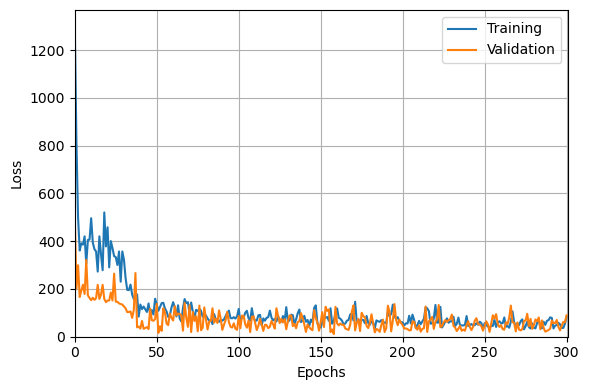

In [7]:
dd = well_moraine_1[['RV72_1DF', 'RH72_1DF', 'GR']].loc[5100:5320]
dd = dd.rename(columns={'RV72_1DF':'Rv', 'RH72_1DF':'Rh', 'GR':'GR', })
dd['Rvsh'] = np.percentile(dd['Rv'], 99.5)
dd['Rhsh'] = np.percentile(dd['Rh'], 99.5)

inputs = torch.tensor(dd.values, dtype=torch.float32).to(device)
dataset = TensorDataset(inputs)
train_percent = 0.85
n_train = int(train_percent * len(dataset))
xtrain, xvalid = random_split(dataset, [n_train, len(dataset)-n_train])
print('X_train: {} | X_valid: {}'.format(len(xtrain), len(xvalid)))

batch_size = 32
trainloader = DataLoader(xtrain, batch_size=batch_size, shuffle=True)
validloader = DataLoader(xvalid, batch_size=batch_size, shuffle=False)

model = ResInvPINN(hidden_dim=128).to(device)
criterion = PINNLoss(ddmax=np.percentile(dd['GR'], 97.5), lambda_reg=1e-6, dd_flag=True).to(device)
mseloss = DataLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print('# paramters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

epochs, monitor = 301, 100
pinn_lambda = 0.80

train_loss, valid_loss = [], []
for epoch in range(epochs):
    
    # training
    epoch_train_loss = []
    model.train()
    for i, x in enumerate(trainloader):
        optimizer.zero_grad()
        y = model(x[0])
        loss = (pinn_lambda)*criterion(x[0], y) + (1-pinn_lambda)*mseloss(x[0], y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for x in validloader:
            y = model(x[0])
            loss = (pinn_lambda)*criterion(x[0], y) + (1-pinn_lambda)*mseloss(x[0], y)
            epoch_valid_loss.append(loss.item())
        valid_loss.append(np.mean(epoch_valid_loss))
    
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

losses = pd.DataFrame({'train':train_loss, 'valid':valid_loss})
plot_loss(losses)

In [8]:
y_pred = model(inputs[:,:2]).cpu().detach().numpy().squeeze()
Csh_pred, Rss_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
print('Csh {}'.format(Csh_pred.shape),' '*7,'- min: {:.4f} | max: {:.4f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = dd['Rv'].values
Rh_true = dd['Rh'].values
Rvsh    = dd['Rvsh'].values
Rhsh    = dd['Rhsh'].values

Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

pinn_sol = pd.DataFrame({'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred, 
                         'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                         'Rv_err':Rv_err, 'Rh_err':Rh_err}, 
                         index=dd.index)
results = pd.concat([dd, pinn_sol], axis=1)
error_metrics(results)

Csh (441,)         - min: 0.1195 | max: 0.9857
Mean Squared Error - Rv: 0.6838  | Rh: 0.1403
R2 Score           - Rv: 95.676  | Rh: 97.332
Standard Error     - Rv: 1.2600  | Rh: 0.9729
MAPE               - Rv: 6.206%  | Rh: 7.098%


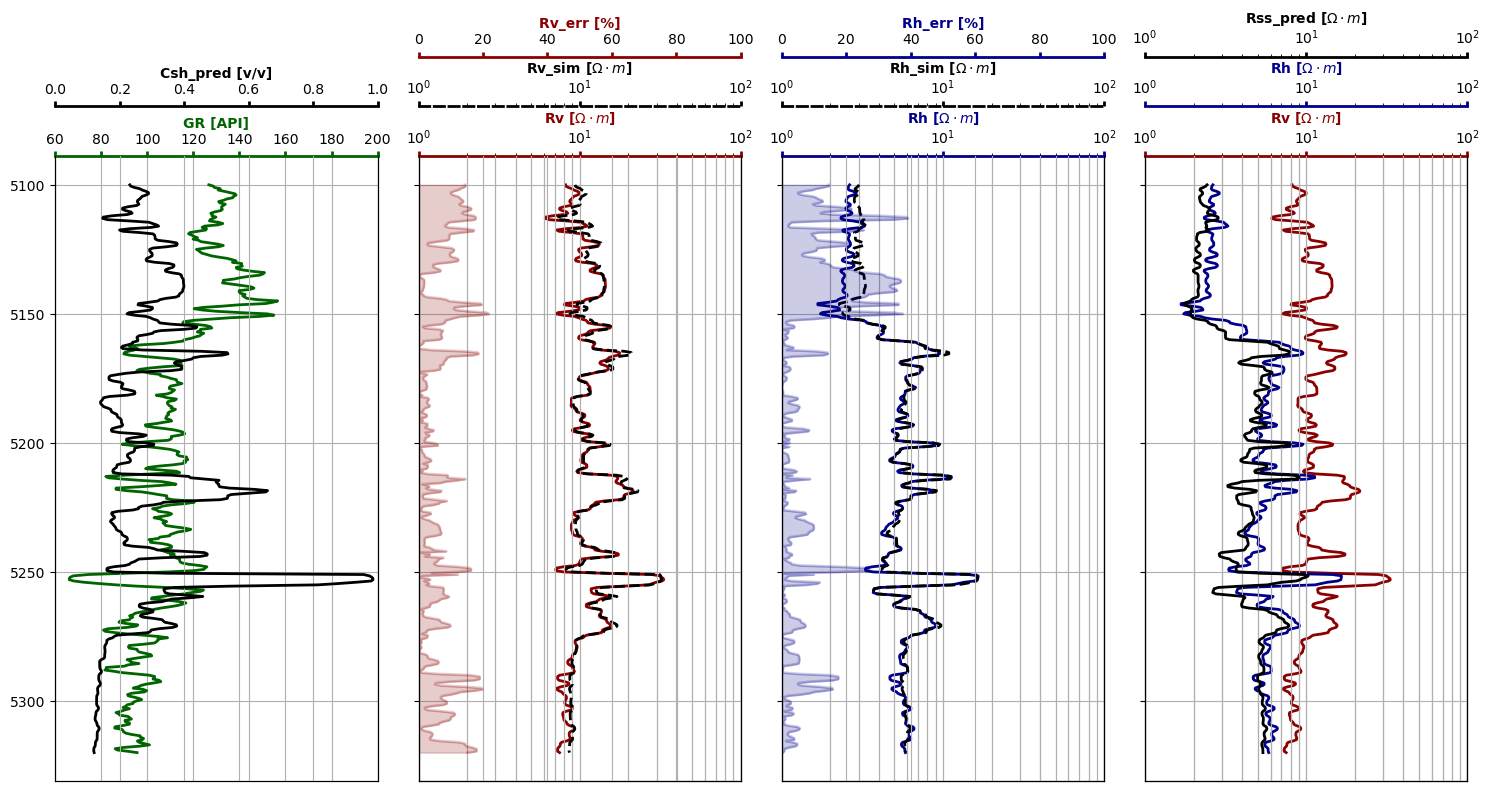

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15,8), sharey=True)
ax1, ax2, ax3, ax4 = axs
rlb, rub = 1, 100

ax11 = ax1.twiny()
plot_curve(ax1, dd, 'GR', units='API', color='darkgreen', lb=60, ub=200)
plot_curve(ax11, results, 'Csh_pred', units='v/v', color='k', lb=0, ub=1, pad=8)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, dd, 'Rv',  units=r'$\Omega \cdot m$', color='darkred', lb=rlb, ub=rub, semilog=True)
plot_curve(ax21, results, 'Rv_sim',  units=r'$\Omega \cdot m$', color='k', ls='--', lb=rlb, ub=rub, semilog=True, pad=8)
plot_curve(ax22, results, 'Rv_err', units='%', color='darkred', lb=0, ub=100, fill=True, alpha=0.2, pad=16)

ax31, ax32 = ax3.twiny(), ax3.twiny()
plot_curve(ax3, dd, 'Rh',  units=r'$\Omega \cdot m$', color='darkblue', lb=rlb, ub=rub, semilog=True)
plot_curve(ax31, results, 'Rh_sim',  units=r'$\Omega \cdot m$', color='k', ls='--', lb=rlb, ub=rub, semilog=True, pad=8)
plot_curve(ax32, results, 'Rh_err', units='%', color='darkblue', lb=0, ub=100, fill=True, alpha=0.2, pad=16)

ax41, ax42 = ax4.twiny(), ax4.twiny()
plot_curve(ax4, dd, 'Rv', units=r'$\Omega \cdot m$', color='darkred', lb=rlb, ub=rub, semilog=True)
plot_curve(ax41, dd, 'Rh', units=r'$\Omega \cdot m$', color='darkblue', lb=rlb, ub=rub, semilog=True, pad=8)
plot_curve(ax42, results, 'Rss_pred', units=r'$\Omega \cdot m$', color='k', lb=rlb, ub=rub, semilog=True, pad=16)

ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
## Data Assimilation

In [10]:
dduq = {}
nuq = 500
for i in range(nuq):
    dduq[i] = dd + np.random.normal(0, 0.25*dd.std(0), size=dd.shape)

csh_uq = np.zeros((nuq, dd.shape[0]))
rss_uq = np.zeros((nuq, dd.shape[0]))
for i in range(nuq):
    xx = torch.tensor(dduq[i][['Rv','Rh']].values, dtype=torch.float32).to(device)
    rr = model(xx.to(device)).cpu().detach().numpy().squeeze()
    csh_uq[i], rss_uq[i] = rr[:, 0], rr[:, 1]
X_prior = csh_uq.copy()

In [11]:
# ESMDA
X = np.moveaxis(csh_uq, 0, 1)
print('X: {}'.format(X.shape))

y_obs = 1-well_moraine_core.values.squeeze()
print('y: {}'.format(y_obs.shape))

idx_log = dd.index.values
idx_core = np.round(well_moraine_core.index.values, 0)
idx_obs = np.where(np.isin(idx_log, idx_core))[0]
R = np.eye(well_moraine_core.shape[0]) * 0.05

H = np.zeros((well_moraine_core.shape[0], csh_uq.shape[1]))
for i, idx in enumerate(idx_obs):
    H[i, idx] = 1
Y = H @ X

n_updates = 4
R_scaled = R / n_updates
y_obs_perturbed = y_obs[:, None] + np.random.multivariate_normal(np.zeros(well_moraine_core.shape[0]), R, size=X.shape[1]).T
for k in tqdm(range(n_updates), desc='ESMDA updates'):
    Y = H @ X
    C_XY = np.cov(X, Y, rowvar=True)[:csh_uq.shape[1], csh_uq.shape[1]:]
    C_YY = np.cov(Y, rowvar=True) + R_scaled
    K = C_XY @ np.linalg.inv(C_YY)
    X += K @ (y_obs_perturbed - Y)
X_posterior = np.clip(X, 0, 1)
print("Updated ensemble shape:", X_posterior.shape)

X: (441, 500)
y: (123,)


ESMDA updates: 100%|██████████| 4/4 [00:00<00:00, 66.45it/s]

Updated ensemble shape: (441, 500)


In [12]:
def forward_posterior(csh_posterior, rss_prior):
    rvsh = results['Rvsh'].values.reshape(-1,1)
    rhsh = results['Rhsh'].values.reshape(-1,1)
    rss = np.moveaxis(rss_prior, 0, 1)
    rv = csh_posterior * rvsh + (1-csh_posterior) * rss
    rh = 1 / (csh_posterior / rhsh + (1-csh_posterior) / rss)
    return rv, rh
rv_posterior, rh_posterior = forward_posterior(X_posterior, rss_uq)

D_posterior = {}
for i in range(nuq):
    D_posterior[i] = pd.DataFrame({'RV':rv_posterior[:, i], 'RH':rh_posterior[:, i]}, index=dd.index)
D_posterior_mean = pd.DataFrame({'RV':rv_posterior.mean(1), 'RH':rh_posterior.mean(1)}, index=dd.index)

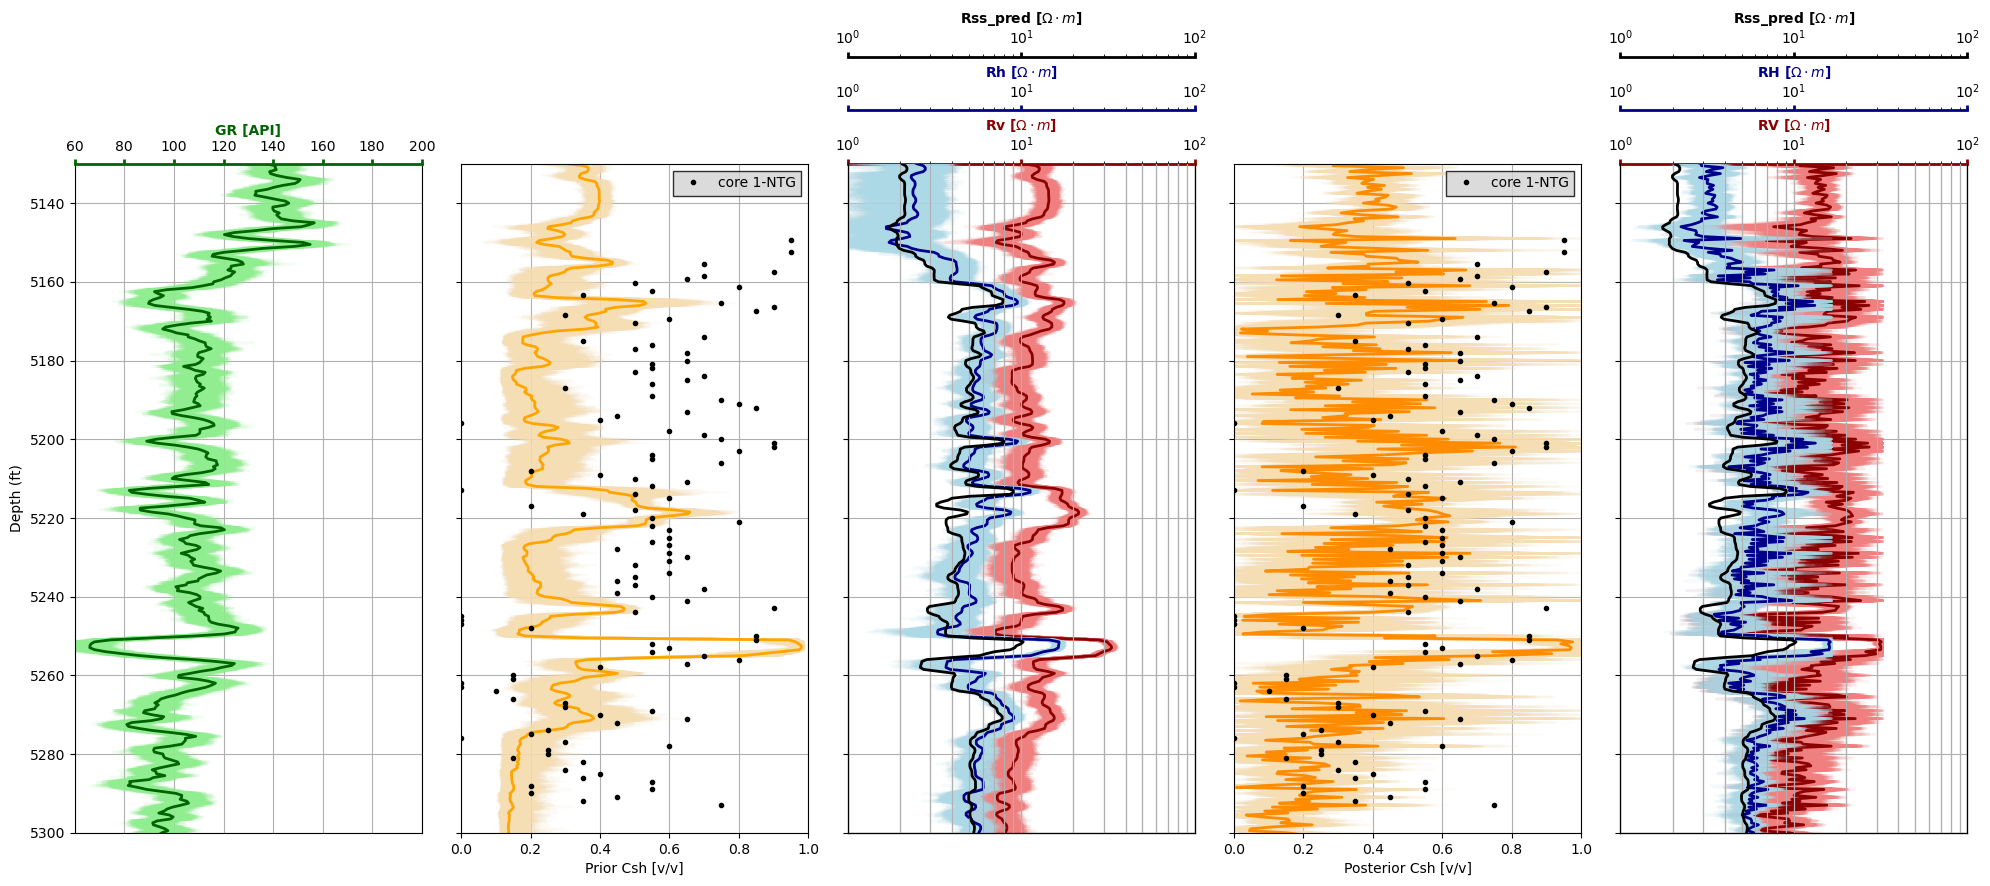

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(20,9), sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs
ax31, ax32, ax51, ax52 = ax3.twiny(), ax3.twiny(), ax5.twiny(), ax5.twiny()

for i in range(nuq):
    plot_curve(ax1, dduq[i], 'GR', units='API', color='lightgreen', lb=40, ub=200, alpha=0.1)
    ax2.plot(X_prior[i], dduq[i].index, color='wheat', alpha=0.1)
    plot_curve(ax3, dduq[i], 'Rv', units=r'$\Omega \cdot m$', color='lightcoral', lb=rlb, ub=rub, semilog=True, alpha=0.1)
    plot_curve(ax31, dduq[i], 'Rh', units=r'$\Omega \cdot m$', color='lightblue', lb=rlb, ub=rub, semilog=True, alpha=0.1)
    ax4.plot(X_posterior[:, i], dduq[i].index, color='wheat', alpha=0.1)
    plot_curve(ax5, D_posterior[i], 'RV', units=r'$\Omega \cdot m$', color='lightcoral', lb=rlb, ub=rub, semilog=True, alpha=0.1)
    plot_curve(ax51, D_posterior[i], 'RH', units=r'$\Omega \cdot m$', color='lightblue', lb=rlb, ub=rub, semilog=True, alpha=0.1)

plot_curve(ax1, dd, 'GR', units='API', color='darkgreen', lb=60, ub=200)

ax2.plot(X_prior.mean(axis=0), dd.index, color='orange', lw=2)

plot_curve(ax3, dd, 'Rv', units=r'$\Omega \cdot m$', color='darkred', lb=rlb, ub=rub, semilog=True)
plot_curve(ax31, dd, 'Rh', units=r'$\Omega \cdot m$', color='darkblue', lb=rlb, ub=rub, semilog=True, pad=8)
plot_curve(ax32, results, 'Rss_pred', units=r'$\Omega \cdot m$', color='black', lb=rlb, ub=rub, semilog=True, pad=16)

ax4.plot(X_posterior.mean(axis=1), dd.index, color='darkorange', lw=2)

plot_curve(ax5, D_posterior_mean, 'RV', units=r'$\Omega \cdot m$', color='darkred', lb=rlb, ub=rub, semilog=True)
plot_curve(ax51, D_posterior_mean, 'RH', units=r'$\Omega \cdot m$', color='darkblue', lb=rlb, ub=rub, semilog=True, pad=8)
plot_curve(ax52, results, 'Rss_pred', units=r'$\Omega \cdot m$', color='black', lb=rlb, ub=rub, semilog=True, pad=16)

# plot settings
ax2.plot(1-well_moraine_core['NTG'], well_moraine_core.index, color='black', marker='.', ls='', label='core 1-NTG')
ax2.set(xlim=(0, 1), xlabel='Prior Csh [v/v]')
ax2.grid(True, which='both')
ax2.legend(facecolor='lightgray', edgecolor='k', fancybox=False, loc='upper right')

ax4.plot(1-well_moraine_core['NTG'], well_moraine_core.index, color='black', marker='.', ls='', label='core 1-NTG')
ax4.set(xlim=(0, 1), xlabel='Posterior Csh [v/v]')
ax4.grid(True, which='both')
ax4.legend(facecolor='lightgray', edgecolor='k', fancybox=False, loc='upper right')

ax1.set(ylim=(5130, 5300), ylabel='Depth (ft)')
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

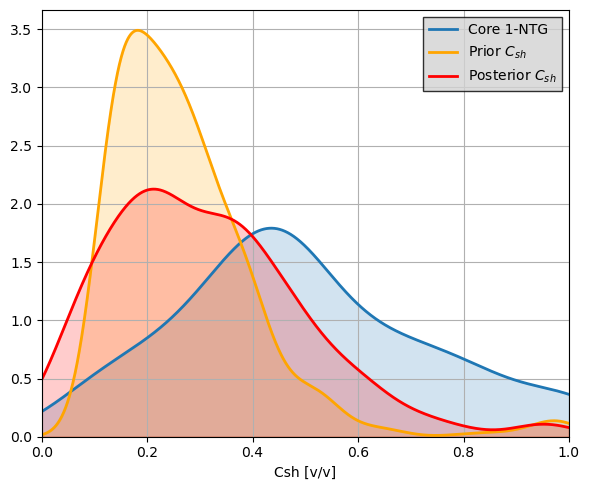

In [14]:
cc = np.linspace(0, 1, 2000)
pdf_true = stats.gaussian_kde(well_moraine_core.values.squeeze())(cc)
pdf_prior = stats.gaussian_kde(results['Csh_pred'].values)(cc)
pdf_posterior = stats.gaussian_kde(X_posterior.mean(axis=1))(cc)

plt.figure(figsize=(6,5))
plt.plot(cc, pdf_true, label='Core 1-NTG', color='C0', lw=2)
plt.plot(cc, pdf_prior, label='Prior $C_{sh}$', color='orange', lw=2)
plt.plot(cc, pdf_posterior, label='Posterior $C_{sh}$', color='red', lw=2)

plt.fill_between(cc, pdf_true, alpha=0.2, color='C0')
plt.fill_between(cc, pdf_prior, alpha=0.2, color='orange')
plt.fill_between(cc, pdf_posterior, alpha=0.2, color='red')

plt.grid(True, which='both')
plt.xlim(0,1); plt.ylim(0,None); plt.xlabel('Csh [v/v]')
plt.legend(facecolor='lightgray', edgecolor='k', fancybox=False)
plt.tight_layout()
plt.show()

***
## Core NTG Conditioning

In [51]:
dd = well_moraine_1[['RV72_1DF', 'RH72_1DF', 'GR']].loc[5100:5320] #.loc[5149:5300]
dd = dd.rename(columns={'RV72_1DF':'Rv', 'RH72_1DF':'Rh', 'GR':'GR', })
dd['Rvsh'] = np.percentile(dd['Rv'], 99.5)
dd['Rhsh'] = np.percentile(dd['Rh'], 99.5)

grmax = dd['GR'].max()
lambda_reg = 1e-2

idx_log = dd.index.values
idx_core = np.round(well_moraine_core.index.values, 0)
idx_obs = np.where(np.isin(idx_log, idx_core))[0]

vsh = np.zeros((len(dd), 1))
vsh[idx_obs] = 1 - well_moraine_core['NTG'].values.reshape(-1,1)
dd['Vsh'] = vsh

cflag = np.zeros((len(dd), 1), dtype=int)
cflag[idx_obs] = 1
dd['cflag'] = cflag

print('Data matrix: {}'.format(dd.shape))

Data matrix: (441, 7)


In [ ]:
# Unconditional inversion
def objective(variables, *args):
    Csh, Rs = variables
    Rv, Rh, Rvsh, Rhsh, grw = args[0], args[1], args[2], args[3], args[4]/grmax
    def loss():
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        return np.expand_dims(np.array([eq1, eq2]),-1)
    def weighting(method='gr'):
        if method=='gr':
            Wd1, Wd2 = 1/Rv/grw, 1*Rh/grw
        elif method=='data':
            Wd1, Wd2 = 1/Rv, 1*Rh
        elif method=='none':
            Wd1, Wd2 = 1, 1
        else:
            raise ValueError('Invalid weighting method')
        return np.diag(np.array([Wd1, Wd2]))
    def reg(v, a=0, o=2):
        return a*linalg.norm(v, o)
    cost = np.dot(weighting(), loss())
    return linalg.norm(cost,2) + reg(variables, a=lambda_reg)

def jacobian(variables, *args):
    return Jacobian(lambda x: objective(x, *args))(variables).ravel()
def hessian(variables, *args):
    return Hessian(lambda x: objective(x, *args))(variables)
bounds = [(0.4,1),(0, 2000)]
constr = (optimize.NonlinearConstraint(lambda x: x[0], lb=bounds[0][0], ub=bounds[0][1]),
          optimize.NonlinearConstraint(lambda x: x[1], lb=bounds[1][0], ub=bounds[1][1]))

xall, xhist  = {}, []
def callback(x, *args):
    xhist.append(x)
sol = []
for i, row in tqdm(dd.iterrows()):
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    GR_value       = row['GR']
    Rvsh_value     = row['Rvsh']
    Rhsh_value     = row['Rhsh']
    x0 = (0.7, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'cg',
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100})
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value,
                'Rvsh':Rvsh_value, 'Rhsh':Rhsh_value, 'GR':GR_value,
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred),
                'Rv_err':1*np.abs(Rv_value - (Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred)),
                'Rh_err':1*np.abs(Rh_value - 1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred))}
                )
    xall[i] = np.array([x0]+xhist)
results_uncond = pd.DataFrame(sol, index=dd.index)
error_metrics(results_uncond)

0it [00:00, ?it/s]

441it [00:17, 25.93it/s]


In [62]:
# Conditional inversion
beta_reg = 10/3

def objective(variables, *args):
    Csh, Rs = variables
    Rv, Rh, Rvsh, Rhsh, grw, Vsh, cflag = args[0], args[1], args[2], args[3], args[4]/grmax, args[5], args[6]
    
    def loss():
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        return np.expand_dims(np.array([eq1, eq2]),-1)
    
    def weighting(method='gr'):
        if method=='gr':
            Wd1, Wd2 = 1/Rv/grw, 1*Rh/grw
        elif method=='data':
            Wd1, Wd2 = 1/Rv, 1*Rh
        elif method=='none':
            Wd1, Wd2 = 1, 1
        else:
            raise ValueError('Invalid weighting method')
        return np.diag(np.array([Wd1, Wd2]))
    
    def reg(v, a=0, o=2):
        return a*linalg.norm(v, o)
    
    cost = np.dot(weighting(), loss())
    diff = cflag*(Csh - Vsh)

    return linalg.norm(cost,2) + reg(variables, a=lambda_reg) + beta_reg*np.sqrt(diff**2)

def jacobian(variables, *args):
    return Jacobian(lambda x: objective(x, *args))(variables).ravel()

def hessian(variables, *args):
    return Hessian(lambda x: objective(x, *args))(variables)

bounds = [(0.4,1),(0, 2000)]
constr = (optimize.NonlinearConstraint(lambda x: x[0], lb=bounds[0][0], ub=bounds[0][1]),
          optimize.NonlinearConstraint(lambda x: x[1], lb=bounds[1][0], ub=bounds[1][1]))

xall, xhist  = {}, []
def callback(x, *args):
    xhist.append(x)

sol = []
for i, row in tqdm(dd.iterrows()):
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    GR_value       = row['GR']
    Rvsh_value     = row['Rvsh']
    Rhsh_value     = row['Rhsh']
    Vsh_value      = row['Vsh']
    core_flag      = row['cflag']

    x0 = (0.7, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, Vsh_value, core_flag)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'SLSQP',
                            #jac         = jacobian,
                            #hess        = hessian,
                            #bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value,
                'Rvsh':Rvsh_value, 'Rhsh':Rhsh_value, 
                'GR':GR_value, 'Vsh':Vsh_value, 'cflag':core_flag,

                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred),
                
                'Rv_err':1*np.abs(Rv_value - (Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred)),
                'Rh_err':1*np.abs(Rh_value - 1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred))}
                )
    
    xall[i] = np.array([x0]+xhist)
results_cond = pd.DataFrame(sol, index=dd.index)
error_metrics(results_cond)

0it [00:00, ?it/s]

441it [00:06, 72.15it/s]

Mean Squared Error - Rv: 10.8786  | Rh: 6.5935
R2 Score           - Rv: 31.201  | Rh: -25.374
Standard Error     - Rv: 0.3631  | Rh: 0.2315
MAPE               - Rv: 8.919%  | Rh: 10.583%


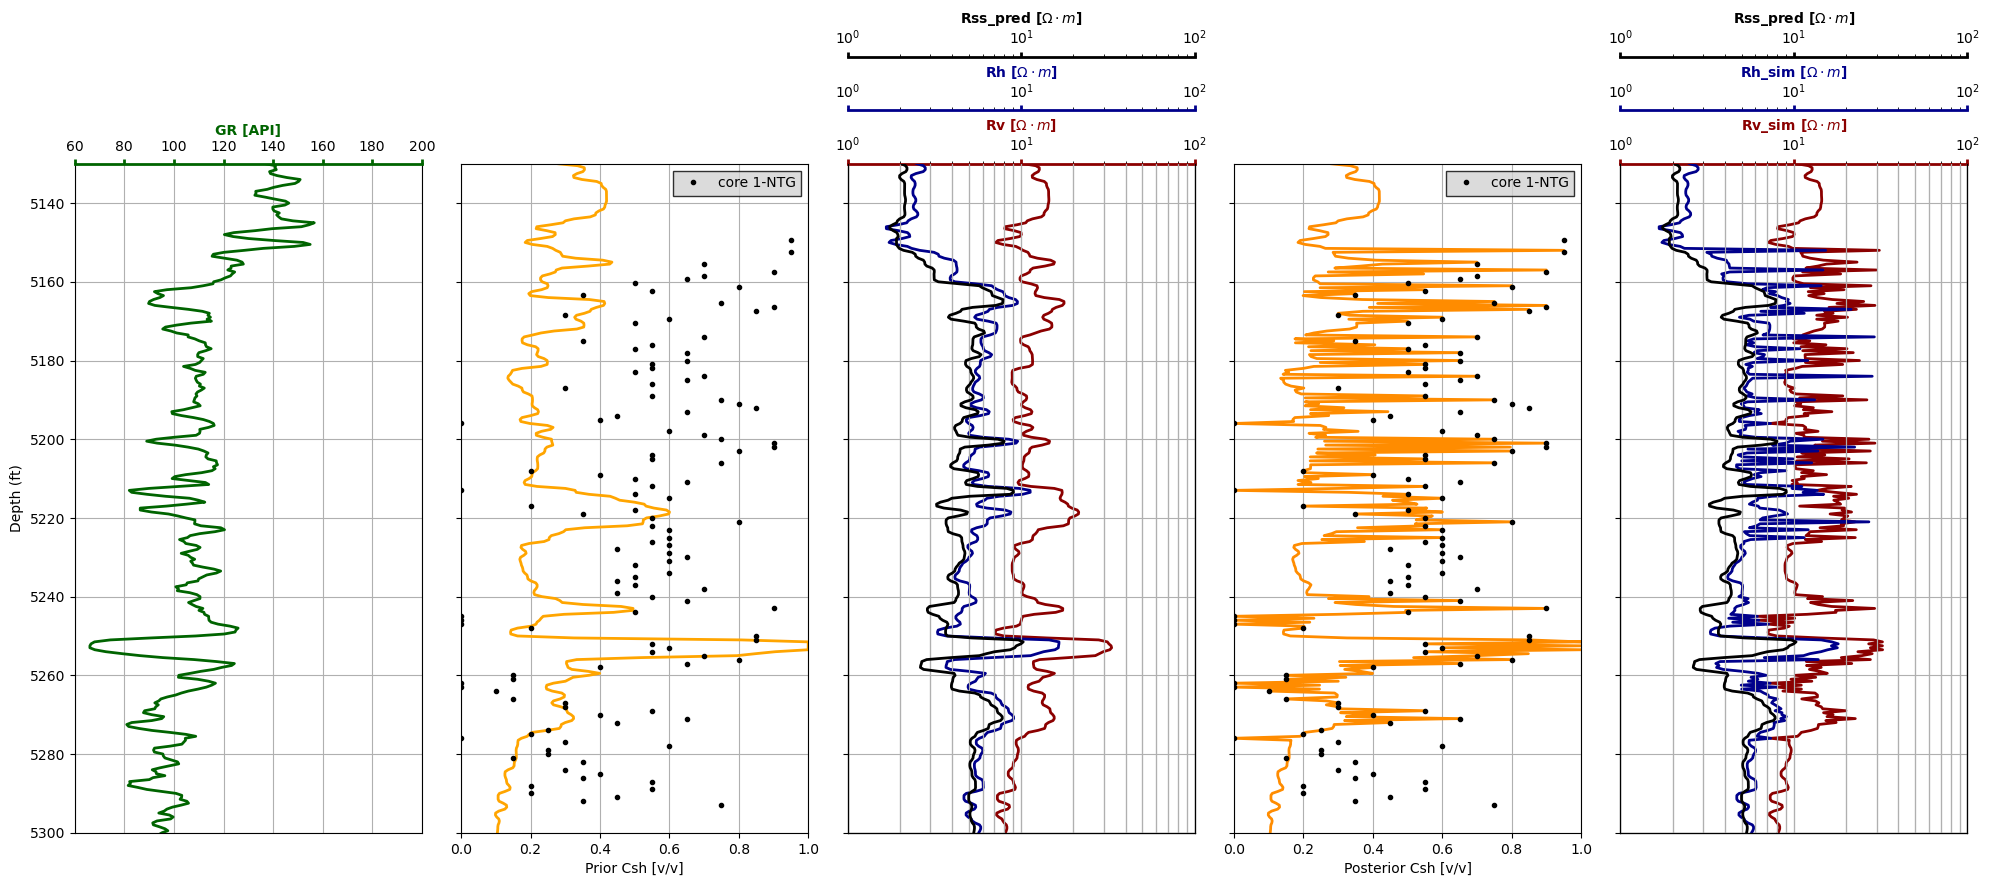

In [63]:
fig, axs = plt.subplots(1, 5, figsize=(20,9), sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs
ax31, ax32, ax51, ax52 = ax3.twiny(), ax3.twiny(), ax5.twiny(), ax5.twiny()

plot_curve(ax1, dd, 'GR', units='API', color='darkgreen', lb=60, ub=200)

ax2.plot(results_uncond['Csh_pred'], dd.index, color='orange', lw=2)

plot_curve(ax3, results_uncond, 'Rv', units=r'$\Omega \cdot m$', color='darkred', lb=rlb, ub=rub, semilog=True)
plot_curve(ax31, results_uncond, 'Rh', units=r'$\Omega \cdot m$', color='darkblue', lb=rlb, ub=rub, semilog=True, pad=8)
plot_curve(ax32, results, 'Rss_pred', units=r'$\Omega \cdot m$', color='black', lb=rlb, ub=rub, semilog=True, pad=16)

ax4.plot(results_cond['Csh_pred'], dd.index, color='darkorange', lw=2)

plot_curve(ax5, results_cond, 'Rv_sim', units=r'$\Omega \cdot m$', color='darkred', lb=rlb, ub=rub, semilog=True)
plot_curve(ax51, results_cond, 'Rh_sim', units=r'$\Omega \cdot m$', color='darkblue', lb=rlb, ub=rub, semilog=True, pad=8)
plot_curve(ax52, results, 'Rss_pred', units=r'$\Omega \cdot m$', color='black', lb=rlb, ub=rub, semilog=True, pad=16)

ax2.plot(1-well_moraine_core['NTG'], well_moraine_core.index, color='black', marker='.', ls='', label='core 1-NTG')
ax2.set(xlim=(0, 1), xlabel='Prior Csh [v/v]')
ax2.grid(True, which='both')
ax2.legend(facecolor='lightgray', edgecolor='k', fancybox=False, loc='upper right')

ax4.plot(1-well_moraine_core['NTG'], well_moraine_core.index, color='black', marker='.', ls='', label='core 1-NTG')
ax4.set(xlim=(0, 1), xlabel='Posterior Csh [v/v]')
ax4.grid(True, which='both')
ax4.legend(facecolor='lightgray', edgecolor='k', fancybox=False, loc='upper right')

ax1.set(ylim=(5130, 5300), ylabel='Depth (ft)')
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

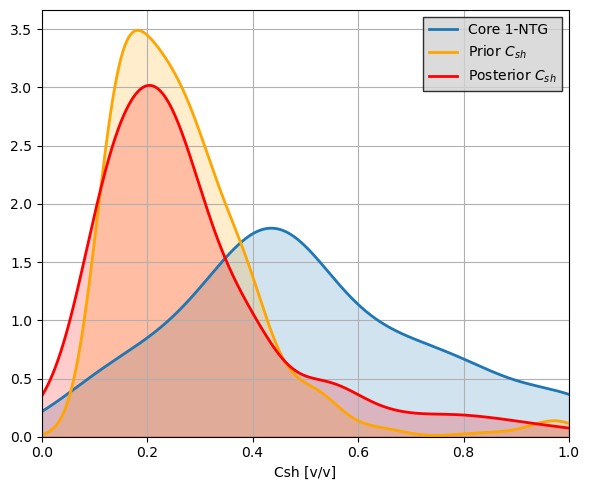

In [64]:
x = np.linspace(0, 1, 2000)
pdf_true = stats.gaussian_kde(well_moraine_core.values.squeeze())(x)
pdf_prior = stats.gaussian_kde(results['Csh_pred'].values)(x)
pdf_posterior = stats.gaussian_kde(results_cond['Csh_pred'])(x)

plt.figure(figsize=(6,5))

plt.plot(x, pdf_true, label='Core 1-NTG', color='C0', lw=2)
plt.plot(x, pdf_prior, label='Prior $C_{sh}$', color='orange', lw=2)
plt.plot(x, pdf_posterior, label='Posterior $C_{sh}$', color='red', lw=2)

plt.fill_between(x, pdf_true, alpha=0.2, color='C0')
plt.fill_between(x, pdf_prior, alpha=0.2, color='orange')
plt.fill_between(x, pdf_posterior, alpha=0.2, color='red')

plt.grid(True, which='both')
plt.xlim(0,1); plt.ylim(0,None); plt.xlabel('Csh [v/v]')
plt.legend(facecolor='lightgray', edgecolor='k', fancybox=False)
plt.tight_layout()
plt.show()

***
# END